In [1]:
import torch
from torch import nn
import torch.optim as optim
from fastai.vision.all import *
import matplotlib.pyplot as plt
from models_module import my_models
from train_module import training_functions

GRAPH_PATH = "./data/graphs"

In [2]:
in_channels = 3
out_channels = 10
device = "cuda:0"
net = my_models.VGG(in_channels = in_channels, 
            out_channels = out_channels,
            conv_blocks_out_size = [64,128,256,512,512],
            conv_blocks_amounts = [2,2,2,2,2],
            linear_layers_out_size = [400,300,out_channels])
net.to(device)

train_loss = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

batch_size = 10
epoch_num = 5

In [3]:
path = URLs.IMAGENETTE_160

In [4]:
trainloader, valloader = training_functions.prepare_train_and_val_dls(path, batch_size, size=160)

In [5]:
%%time
net, optimization_history = training_functions.train(net, optimizer, 
                                                     train_loss, epoch_num,
                                                     trainloader, valloader, 
                                                     device, GRAPH_PATH+"test_info.jpg")

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

In [6]:
accuracy, conf_matrix, precision, recall, f1 = training_functions.test_metrics(net, device, valloader, out_channels)

print("Test accuracy: ", accuracy)
print("Test precision: ", precision)
print("Test recall: ", recall)
print("Test f-measure: ", f1)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fc33bbcd240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1150, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/usr/local/lib/python3.6/dist-packages/fastai/data/load.py", line 110, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/usr/local/lib/python3.6/dist-packages/fastai/data/load.py", line 133, in do_batch
    def do_batch(self, b): return self.retain(self.create_batch(self.before_batch(b)), b)
  File "/usr/local/lib/python3.6/dist-packages/fastai/data/load.py", line 132, in create_batch
    def create_batch(self, b): return (fa_collate,fa_convert)[self.prebatched](b)
  File "/usr/local/lib/python3.6/dist-packages/fastai/data/load.py", line 48, in fa_collate
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
  File "/usr/local/lib/python3.6/dist-packages/fastai/data/load.py", line 48, in <listcomp>
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
  File "/usr/local/lib/python3.6/dist-packages/fastai/data/load.py", line 47, in fa_collate
    return (default_collate(t) if isinstance(b, _collate_types)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/collate.py", line 53, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "/usr/local/lib/python3.6/dist-packages/torch/storage.py", line 137, in _new_shared
    return cls._new_using_fd(size)
RuntimeError: unable to write to file </torch_23766_1867350046>


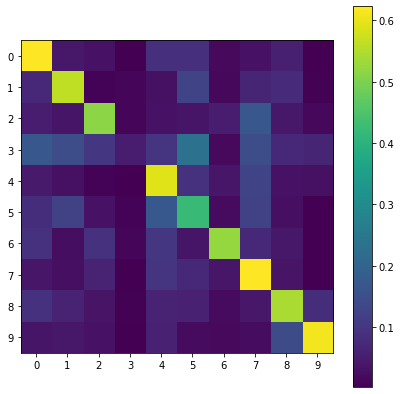

In [17]:
plt.figure(figsize=(7, 7))

plt.imshow(conf_matrix)
plt.xticks(range(conf_matrix.shape[0]))
plt.yticks(range(conf_matrix.shape[0]))
plt.colorbar()
plt.show()

In [18]:
data, labels = valloader.one_batch()

In [9]:
labels_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]

In [10]:
outputs = net(data)
_, predicted = torch.max(outputs.detach(), 1)

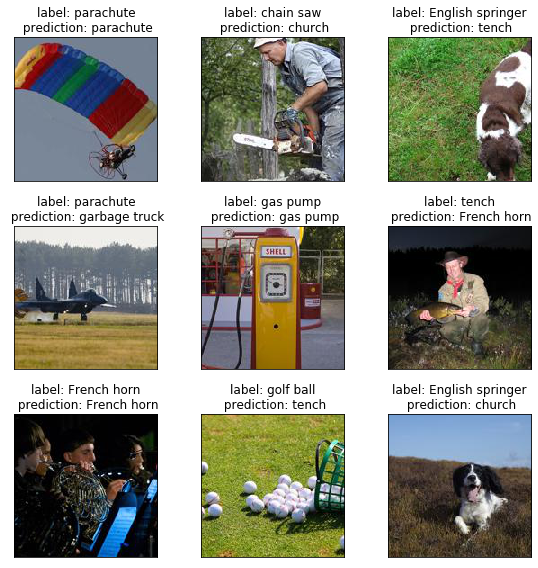

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    ax.imshow(data[picture_num].cpu().permute(1, 2, 0))
    ax.set_title("label: {}\n prediction: {}".format(labels_names[labels[picture_num]], 
                                                     labels_names[predicted[picture_num]]))

plt.tight_layout()
plt.show()